# ModelV2
Improves of V1 by taking G-Buffers as input and G-buffer feature extractor.

In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS\jupyter_notebooks
c:\Dev\MinorProject\WDSS


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from config import Settings, device
from network.modules.feature_extractors import HRGBufferFeatureExtractor, LRFrameFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from utils.image_utils import ImageUtils
from network.dataset import WDSSDatasetCompressed, GB_Type

from typing import List, Tuple, Union

# Model

In [3]:
class WDSSV2(nn.Module):
    def __init__(self):
        super(WDSSV2, self).__init__()

        self.upscale_factor = 2
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(48, 32, [64, 64, 64, 64])
        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 32, [32, 32])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffers: torch.Tensor) -> torch.Tensor:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffers, 2)

        lr_frame_features = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        # Upsample the low resolution frame features
        lr_frame_features_upsampled = F.interpolate(lr_frame_features, scale_factor=self.upscale_factor, mode='nearest')

        hr_gbuffers_features = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Concatenate the features
        features = torch.cat((lr_frame_features_upsampled, hr_gbuffers_features), dim=1)

        # Fuse the features
        output_pre_pixel_shuffle = self.feature_fusion(features)

        # Pixel shuffle the output
        output = F.pixel_shuffle(output_pre_pixel_shuffle, 2)

        return output


# Dataset

In [4]:
dataset_folder = "D:\\Dev\\MinorProjDataset\\V2\\train"

dataset = WDSSDatasetCompressed(dataset_folder, 120)
print(len(dataset))

120


In [5]:
# Model
model = WDSSV2().to(device)

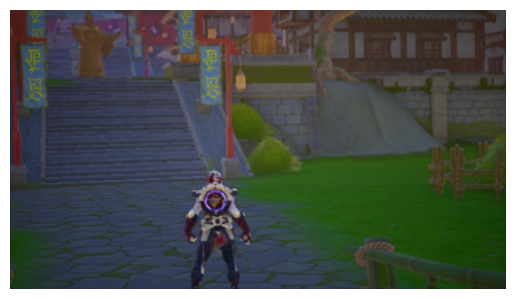

In [40]:
model.eval()
with torch.no_grad():
    res = model(dataset[0]['LR'].unsqueeze(0).to(device), dataset[0]['GB'].unsqueeze(0).to(device))
    ImageUtils.display_image(res.cpu())

In [38]:
# Training Loop
import threading

# Criterion is combination of MSE and SSIM
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()

    def forward(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        mse_loss = F.mse_loss(output, target)
        # Calculate SSIM
        ssim_loss = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(output, target, dim=1) + 1) / 2, 0, 1))
        return mse_loss + ssim_loss

criterion = Criterion()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# Dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 10
epoch_loss: float = 0

In [39]:
# # Training Loop
# import threading

# # Criterion
# criterion = nn.MSELoss()
# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# # Dataloader
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 10
epoch_loss: float = 0

def do_nothing():
    ...

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_frames = batch['HR'].to(device)

    optimizer.zero_grad()

    output = model(lr_frames, hr_gbuffers)
    loss = criterion(output, hr_frames)
    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i}, Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(dataloader):
        # print("Data loading completed")

        # Wait for the previous batch to finish
        if threadu.is_alive():
            threadu.join()

        # print(f"Batch {i} started")

        # Start the training process
        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if threadu.is_alive():
        threadu.join()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

# Save the model
torch.save(model.state_dict(), "model/WDSSV2.pth")
    


Batch 0, Loss: 0.00018273699970450252
Batch 1, Loss: 0.011668136343359947
Batch 2, Loss: 0.0017606625333428383
Batch 3, Loss: 0.003192148171365261
Batch 4, Loss: 0.004266120493412018
Batch 5, Loss: 0.0042797052301466465
Batch 6, Loss: 0.00304544810205698
Batch 7, Loss: 0.001571042463183403
Batch 8, Loss: 0.0007415758445858955
Batch 9, Loss: 0.000664888066239655
Batch 10, Loss: 0.0010138012003153563
Batch 11, Loss: 0.001132560078985989
Batch 12, Loss: 0.0013932229485362768
Batch 13, Loss: 0.0013008910464122891
Batch 14, Loss: 0.0014996069949120283
Epoch: 0, Loss: 0.03771254651655909
Batch 0, Loss: 0.0014150184579193592
Batch 1, Loss: 0.001059136469848454
Batch 2, Loss: 0.0009105312637984753
Batch 3, Loss: 0.0009013537201099098
Batch 4, Loss: 0.0007588259177282453
Batch 5, Loss: 0.0007027128012850881
Batch 6, Loss: 0.0008575540268793702
Batch 7, Loss: 0.0008349413401447237
Batch 8, Loss: 0.0007954004104249179
Batch 9, Loss: 0.0009222501539625227
Batch 10, Loss: 0.0008529439801350236
Batc

In [33]:
# Save the model
torch.save(model.state_dict(), "model/WDSSV2.pth")

In [15]:
# Load the model
model.load_state_dict(torch.load("model/WDSSV2.pth"))

C:\Users\Prateek\AppData\Local\Temp\ipykernel_13100\2140453746.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/WDSSV2.pth"))


<All keys matched successfully>

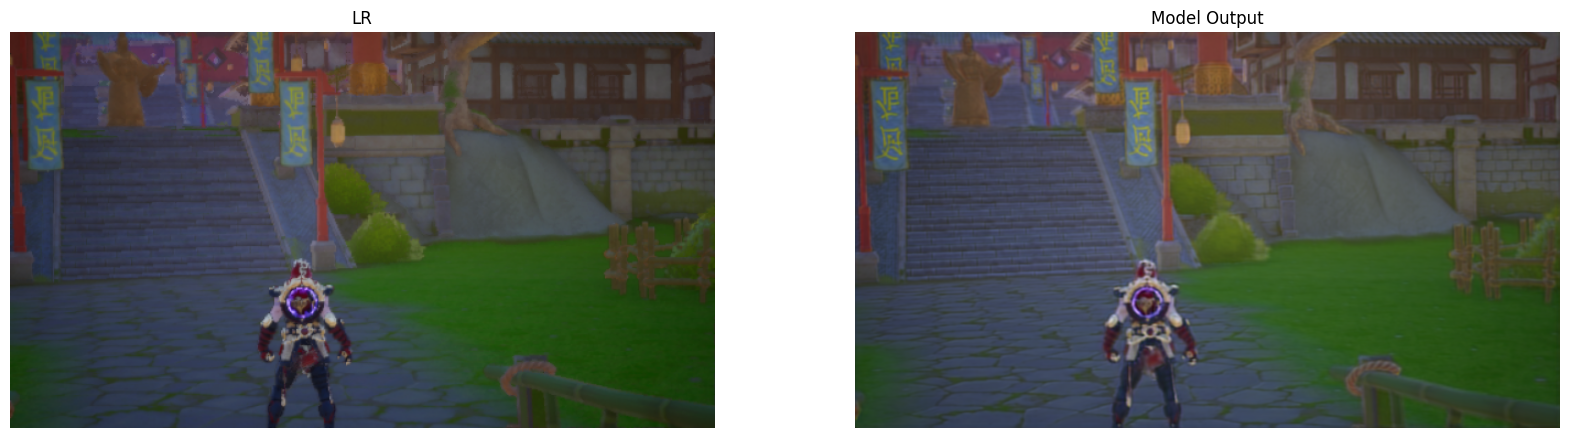

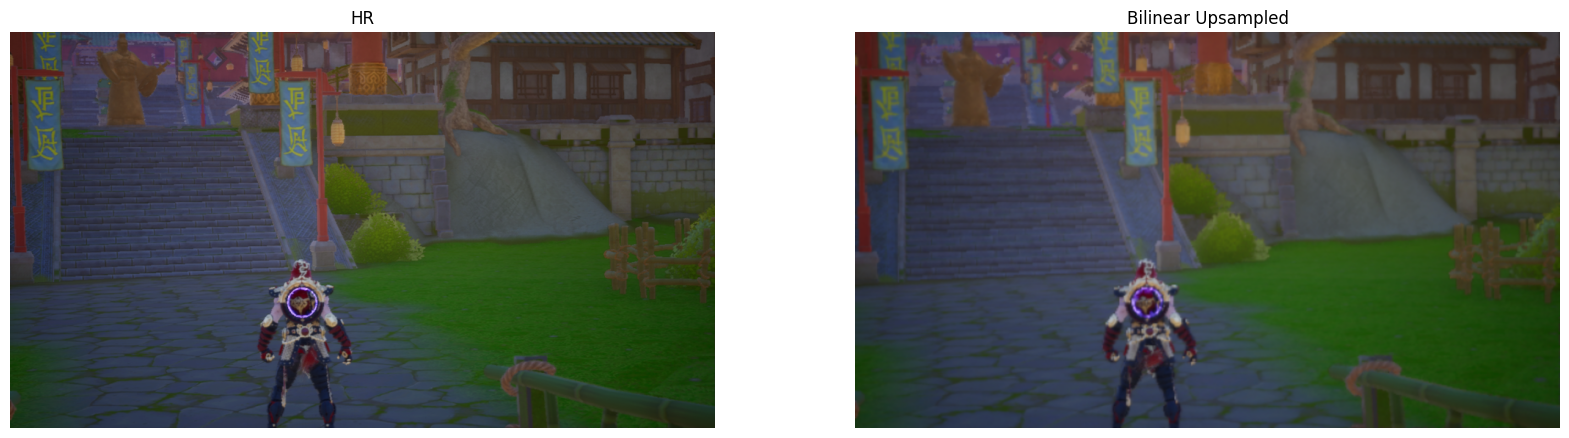

Model Error: 0.0004151815955992788, Bilinear Error: 0.0004791444807779044
Model SSIM: 0.0, Bilinear SSIM: 0.0


In [41]:
# Compare the models output with bilinear upsampled output
frame_no = 0

model.eval()
with torch.no_grad():
    res = model(dataset[frame_no]['LR'].unsqueeze(0).to(device), dataset[frame_no]['GB'].unsqueeze(0).to(device))
    binilear_upsampled = F.interpolate(dataset[frame_no]['LR'].unsqueeze(0), scale_factor=2, mode='bilinear')
    ImageUtils.display_images([dataset[frame_no]['LR'].unsqueeze(0) ,res.cpu()],
                              ["LR", "Model Output"])
    ImageUtils.display_images([dataset[frame_no]['HR'].unsqueeze(0), binilear_upsampled],
                              ["HR", "Bilinear Upsampled"])

# Compare the error between the models output and bilinear upsampled output
model_error = F.mse_loss(res.cpu(), dataset[frame_no]['HR'].unsqueeze(0))
bilinear_error = F.mse_loss(binilear_upsampled, dataset[frame_no]['HR'].unsqueeze(0))

model_ssim = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(res.cpu(), dataset[frame_no]['HR'].unsqueeze(0), dim=1) + 1) / 2, 0, 1))
bilinear_ssim = 1 - torch.mean(torch.clamp((2 * F.cosine_similarity(binilear_upsampled, dataset[frame_no]['HR'].unsqueeze(0), dim=1) + 1) / 2, 0, 1))

print(f"Model Error: {model_error}, Bilinear Error: {bilinear_error}")
print(f"Model SSIM: {model_ssim}, Bilinear SSIM: {bilinear_ssim}")

